In [218]:
import sys
sys.path.append('../kalman-jax-master/kalmanjax/')
import numpy as np
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import time
from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot
from sklearn.preprocessing import StandardScaler



In [219]:
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy


sys.path.append('../../timeseries/')
sys.path.append('../../src/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM
from sklearn.covariance import EmpiricalCovariance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

import darts
from darts.models import TCNModel
from darts.models import GaussianProcessFilter
from darts.utils.likelihood_models import GaussianLikelihoodModel
from darts.timeseries import TimeSeries
from exp_utils import *


In [220]:
x_tr, x_va, x_te, _, s_tr_x = load_energy_e1(ts=0, train_ratio=0.5)

/work/gaussian-toolbox/timeseries/experiments_scripts/exp_utils.py:40: RuntimeWarning: invalid value encountered in greater
  y[x > 10] = x[x > 10]
/work/gaussian-toolbox/timeseries/experiments_scripts/exp_utils.py:41: RuntimeWarning: invalid value encountered in less_equal
  tmp = np.amax(np.stack([x[x <= 10], 1e-5 * np.ones(x[x<=10].shape)]), 0)
/work/gaussian-toolbox/timeseries/experiments_scripts/exp_utils.py:43: RuntimeWarning: invalid value encountered in less_equal
  y[x <= 10] = np.log(np.exp(tmp) - 1)


In [195]:
#help(sm.tsa.DynamicFactor)

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


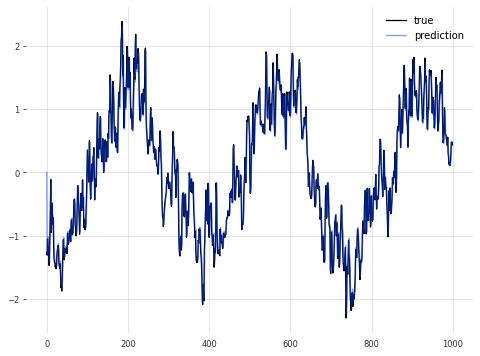

In [295]:
import statsmodels.api as sm

# Load your dataset
#endog = pd.read_csv('your/dataset/here.csv')
x_tr_df = pd.DataFrame(x_tr)

# Create a dynamic factor model
mod_dfm = sm.tsa.DynamicFactor(x_tr_df, k_factors=1, factor_order=1, error_cov_type='diagonal', error_order=1)
# Note that mod_dfm is an instance of the DynamicFactorMQ class
# Fit the model via maximum likelihood, using the EM algorithm
res_dfm = mod_dfm.fit()
# Note that res_dfm is an instance of the DynamicFactorMQResults class

# Show the summary of results
# print(res_dfm.summary())

predictions = np.asarray(res_dfm.fittedvalues)#res_dfm.predict(params=res_dfm.params))
plt.figure(figsize=(8, 6))
plt.plot(x_tr[:1000, 1], label = 'true')
plt.plot(predictions[:1000, 1], alpha=0.5, label = 'prediction')
plt.legend()

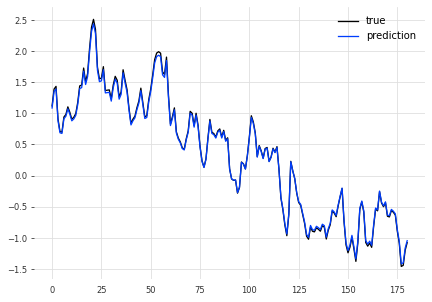

In [296]:
mod_dfm_cl_te = mod_dfm.clone(x_te)
#res = mod_dfm_cl_te.fit(params=res_dfm.params)
res = mod_dfm_cl_te.smooth(params=res_dfm.params, return_ssm=True)
predictions = res.forecasts.T#mod_dfm_cl_te.predict()
plt.figure(figsize=(7, 5))
ixd = 1
plt.plot(x_te[1:, ixd], label = 'true')
plt.plot(predictions[2:, ixd], alpha=1, label = 'prediction')
plt.legend()

In [ ]:
#help(res)
#print(res.__dict__)
#predictions.shape

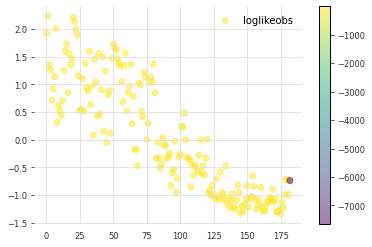

In [297]:
lls = np.asarray(mod_dfm_cl_te.loglikeobs(params=res_dfm.params))
plt.scatter(list(range(x_te.shape[0])), x_te[:, 0],  c=lls, alpha=0.5,  label = 'loglikeobs')
#plt.plot(lls[:], alpha=0.5, label = 'loglikeobs')
plt.colorbar()
plt.legend()

In [298]:
lls[:-1].sum()

-1053.486602528992

In [30]:
var_f1 = 3.  # GP variance
len_f1 = 1.  # GP lengthscale
var_f2 = 3.  # GP variance
len_f2 = 1.  # GP lengthscale

prior1 = priors.Matern32(variance=var_f1, lengthscale=len_f1)
prior2 = priors.Matern32(variance=var_f2, lengthscale=len_f2)
prior = priors.Independent([prior1, prior2])
lik = likelihoods.HeteroscedasticNoise()

# inf_method = approx_inf.ExpectationPropagation(power=0.9, intmethod='UT', damping=0.1)
inf_method = approx_inf.ExpectationPropagation(power=0.01, intmethod='GH', damping=0.5)
model = SDEGP(prior=prior, likelihood=lik, t=np.asarray(list(range(x_tr.shape[0]))), y=x_tr, approx_inf=inf_method)

building SDE-GP with Independent prior and Heteroscedastic Noise likelihood ...
inference method is Expectation Propagation (EP)


In [32]:
opt_init, opt_update, get_params = optimizers.adam(step_size=5e-2)
# parameters should be a 2-element list [param_prior, param_likelihood]
opt_state = opt_init([model.prior.hyp, model.likelihood.hyp])


def gradient_step(i, state, mod):
    params = get_params(state)
    mod.prior.hyp = params[0]
    mod.likelihood.hyp = params[1]

    # grad(Filter) + Smoother:
    neg_log_marg_lik, gradients = mod.run()
    # neg_log_marg_lik, gradients = mod.run_two_stage()  # <-- less elegant but reduces compile time

    prior_params = softplus_list(params[0])
    if (i % 10) == 0:
        print('iter %2d: var_f1=%1.2f len_f1=%1.2f var_f2=%1.2f len_f2=%1.2f, nlml=%2.2f' %
              (i, prior_params[0][0], prior_params[0][1], prior_params[1][0], prior_params[1][1], neg_log_marg_lik))

    #if plot_intermediate:
    #    plot(mod, i)

    return opt_update(i, gradients, state)

In [33]:
plot_intermediate = False
print('optimising the hyperparameters ...')
t0 = time.time()
for j in range(200):
    opt_state = gradient_step(j, opt_state, model)
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

optimising the hyperparameters ...
iter  0: var_f1=3.00 len_f1=1.00 var_f2=3.00 len_f2=1.00, nlml=1959.86
iter 10: var_f1=2.53 len_f1=1.34 var_f2=2.53 len_f2=1.25, nlml=1745.33
iter 20: var_f1=2.08 len_f1=1.74 var_f2=2.08 len_f2=1.62, nlml=1511.36
iter 30: var_f1=1.65 len_f1=2.15 var_f2=1.66 len_f2=2.07, nlml=1274.96
iter 40: var_f1=1.27 len_f1=2.55 var_f2=1.31 len_f2=2.59, nlml=1054.04
iter 50: var_f1=0.94 len_f1=2.93 var_f2=1.07 len_f2=3.13, nlml=868.03
iter 60: var_f1=0.69 len_f1=3.27 var_f2=0.96 len_f2=3.66, nlml=726.33
iter 70: var_f1=0.50 len_f1=3.57 var_f2=0.97 len_f2=4.16, nlml=625.24
iter 80: var_f1=0.39 len_f1=3.83 var_f2=1.09 len_f2=4.62, nlml=555.95
iter 90: var_f1=0.32 len_f1=4.08 var_f2=1.25 len_f2=5.04, nlml=509.15
iter 100: var_f1=0.28 len_f1=4.31 var_f2=1.42 len_f2=5.40, nlml=477.23
iter 110: var_f1=0.26 len_f1=4.53 var_f2=1.58 len_f2=5.73, nlml=454.03
iter 120: var_f1=0.26 len_f1=4.74 var_f2=1.71 len_f2=6.02, nlml=435.28
iter 130: var_f1=0.26 len_f1=4.94 var_f2=1.82 l

In [34]:
x_plot = x_te#np.linspace(np.min(x_tr[:-1])-0.2, np.max(x_tr[:-1])+0.2, x_tr.shape[0])
print('calculating the posterior predictive distribution ...')
t0 = time.time()
nlpd = model.negative_log_predictive_density(t=x_te[:-1], y=x_te[1:])
posterior_mean, posterior_cov = model.predict(t=x_plot)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))
print('NLPD: %1.2f' % nlpd)

calculating the posterior predictive distribution ...
prediction time: 4.33 secs
NLPD: 3.54


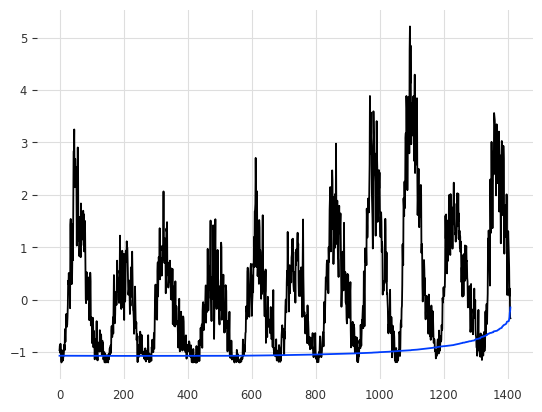

In [36]:
plt.plot(x_te)
plt.plot(posterior_mean[:,1])
plt.show()

In [16]:
x_tr.shape

(1269, 1)